# Cats and Dogs with Transfer Learning

# Imports


In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from tensorflow.keras import layers

# Part 1: Use a TensorFlow Hub MobileNet for prediction

In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).
*Download* the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model1 = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

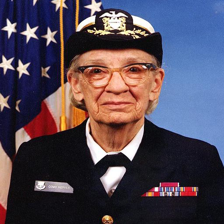

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
#prediction needs an additional fake dimension to mimick batch
result = model1.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 9s 9s/step


(1, 1001)

In [7]:
#Select the max probability from 1001 classes
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

10484/10484 [==============================] - 0s 0us/step


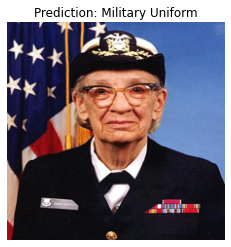

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: Cats vs. Dogs dataset

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteYYWQRM/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [19]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [21]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


1/1 [==============================] - 0s 119ms/step


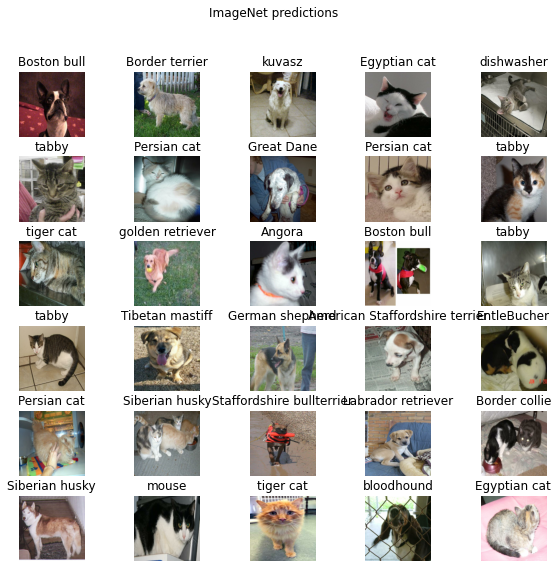

In [23]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model1.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

In [25]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [26]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [29]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [32]:
model2 = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model2.summary()

model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history2 = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/6
582/582 [==============================] - 55s 79ms/step - loss: 0.0508 - accuracy: 0.9830 - val_loss: 0.0357 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 41s 61ms/step - loss: 0.0295 - accuracy: 0.9898 - val_loss: 0.0323 - val_accuracy: 0.9893
Epoch 3/6
582/582 [==============================] - 45s 67ms/step - loss: 0.0243 - accuracy: 0.9917 - val_loss: 0.0332 - val_accuracy: 0.9899
Epoch 4

You can see we get ~99% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

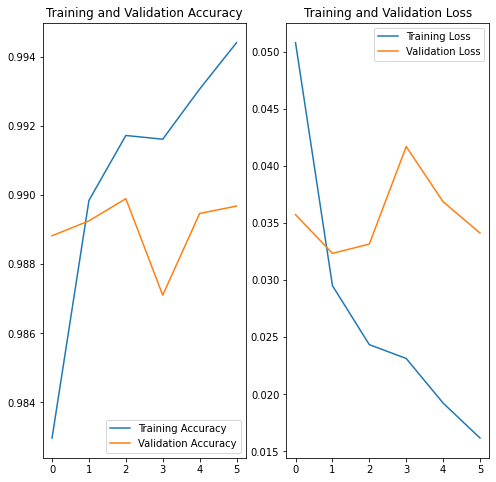

In [33]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Why validation performance is better than training performance?**

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [34]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

1/1 [==============================] - 0s 35ms/step
[[-1.2164675  1.8170362]
 [-7.104437   4.9891014]
 [-4.0656376  1.8688265]
 [10.72031   -9.053245 ]
 [ 4.7973604 -5.277978 ]
 [ 5.7284555 -4.6064553]
 [ 8.141102  -7.272358 ]
 [-5.6208954  4.6813145]
 [ 7.8901978 -6.356948 ]
 [ 6.8819513 -6.2727814]
 [ 5.8463373 -5.510922 ]
 [-7.00756    6.290941 ]
 [ 8.244295  -6.1827636]
 [-3.9540327  3.1939373]
 [ 6.659496  -8.088889 ]
 [ 5.253907  -4.6886015]
 [-8.594325   6.7485456]
 [-3.9582274  3.1456432]
 [-5.5744944  4.711137 ]
 [-3.8959165  2.3108184]
 [ 2.2006905 -1.4837537]
 [ 4.275158  -4.6490593]
 [-7.1490135  4.0439706]
 [-6.6363454  4.460864 ]
 [ 3.4217975 -3.7538223]
 [-2.5834374  2.0858157]
 [ 9.873843  -8.391745 ]
 [ 8.054388  -7.54524  ]
 [-8.96155    7.8144464]
 [ 5.385231  -5.8475175]
 [-6.281557   5.5290174]
 [ 8.4865465 -7.6851287]]
Labels:  [1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0]
Predicted labels:  [1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 

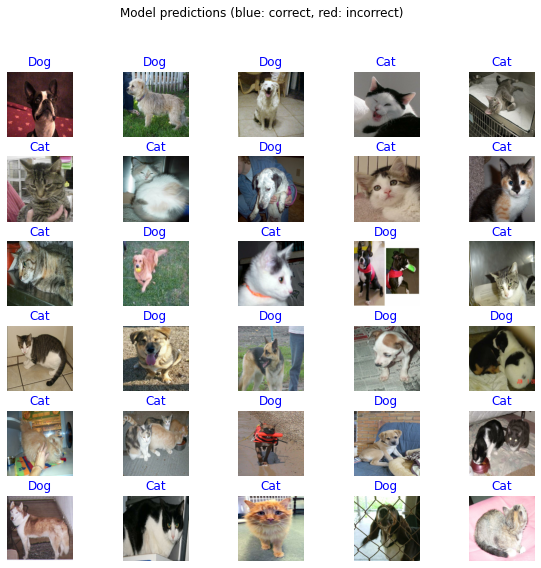

In [42]:
predicted_batch = model2.predict(image_batch)
print(predicted_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")